In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input, AveragePooling2D, LSTM, Reshape,GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, History, ReduceLROnPlateau ,TensorBoard
from keras import regularizers
from keras.applications.vgg16 import VGG16

from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import cv2
from keras.models import load_model
from keras_preprocessing.image import load_img, img_to_array, ImageDataGenerator

In [3]:
class_dic = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}        


In [4]:
# Preprocess all train images
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    vertical_flip=True,
    rotation_range=30,
    zoom_range=0.2
)

train_generator = train_data_gen.flow_from_directory(
        'FER-2013/train',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical'
)


Found 28709 images belonging to 7 classes.


In [5]:
# Preprocess all test images
validation_data_gen = ImageDataGenerator(
      rescale=1./255,
    vertical_flip=True,
    rotation_range=30,
    zoom_range=0.2
)

validation_generator = validation_data_gen.flow_from_directory(
        'FER-2013/test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 7178 images belonging to 7 classes.


In [6]:
from collections import Counter
train_counter = Counter(train_generator.classes)
val_counter = Counter(validation_generator.classes)

print(train_counter.items())
print(val_counter.items())

dict_items([(0, 3995), (1, 436), (2, 4097), (3, 7215), (4, 4965), (5, 4830), (6, 3171)])
dict_items([(0, 958), (1, 111), (2, 1024), (3, 1774), (4, 1233), (5, 1247), (6, 831)])


In [7]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Get the class labels from the generator
train_labels = train_generator.classes
validation_labels = validation_generator.classes

# Compute the class weights
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(train_labels), 
    y=train_labels
)

# Convert the class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

print(class_weights_dict)

{0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


### Model Architecture

In [8]:
def Cnn_Lstm_model():

    model = Sequential([

    Input((48, 48, 1)),
    
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.1),

    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.1),

    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    
    Reshape((-1,128)),
    (LSTM(128)),
    Dropout(0.3),

    (Reshape((-1,64))),
    LSTM(64),
    
    Dense(200, activation='relu'),
    Dropout(0.3),

    Dense(7, activation = 'softmax')
    
    ])

    keras.utils.plot_model(model, to_file = "CNN_LSTM_model.png", show_shapes = True, show_dtype = True)

    model.summary()
    return model

In [9]:
lr_reduce = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=3, 
    verbose=1
)

Earlystop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose =1,
)

TensBoard = TensorBoard(
    log_dir = 'logs-AugW_weightedClass'
)

checkpoint = ModelCheckpoint(
    filepath = 'AugW_weightedClass.h5',
    verbose = 1,
    save_best_only = True
)

In [10]:
model = Cnn_Lstm_model()
epochs = 100
adam = keras.optimizers.Adam(learning_rate=0.002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 46, 46, 64)        0

In [12]:
# Train the neural network/model
history = model.fit(
        train_generator,
        epochs = 100,
        validation_data = validation_generator,
        callbacks= [lr_reduce, Earlystop, TensBoard, checkpoint],
        class_weight=class_weights_dict
)

Epoch 1/100
449/449 [==============================] - ETA: 0s - loss: 1.8661 - accuracy: 0.2127
Epoch 1: val_loss improved from inf to 1.94841, saving model to AugW_weightedClass.h5
449/449 [==============================] - 235s 501ms/step - loss: 1.8661 - accuracy: 0.2127 - val_loss: 1.9484 - val_accuracy: 0.1597 - lr: 0.0020
Epoch 2/100
449/449 [==============================] - ETA: 0s - loss: 1.6502 - accuracy: 0.3584
Epoch 2: val_loss improved from 1.94841 to 1.78411, saving model to AugW_weightedClass.h5
449/449 [==============================] - 221s 492ms/step - loss: 1.6502 - accuracy: 0.3584 - val_loss: 1.7841 - val_accuracy: 0.3115 - lr: 0.0020
Epoch 3/100
449/449 [==============================] - ETA: 0s - loss: 1.5144 - accuracy: 0.4123
Epoch 3: val_loss improved from 1.78411 to 1.47858, saving model to AugW_weightedClass.h5
449/449 [==============================] - 221s 492ms/step - loss: 1.5144 - accuracy: 0.4123 - val_loss: 1.4786 - val_accuracy: 0.4271 - lr: 0.0020

### Accuracy & Loss plots

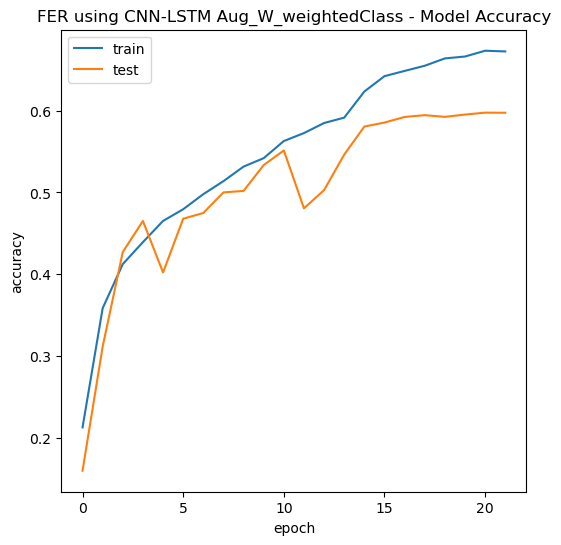

In [13]:
acc = plt.figure(figsize = (6,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('FER using CNN-LSTM Aug_W_weightedClass - Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
acc.savefig("ACC-p4")
plt.show()


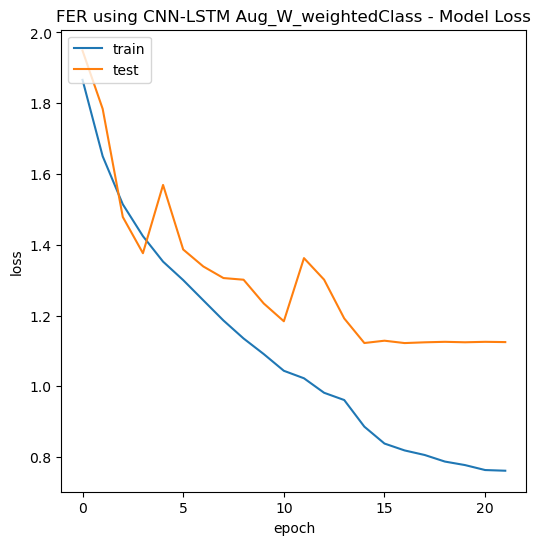

In [14]:
loss = plt.figure(figsize = (6,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('FER using CNN-LSTM Aug_W_weightedClass - Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
loss.savefig("LOSS-p4")
plt.show()

In [15]:
prediction = model.predict(validation_generator)

113/113 [==============================] - 14s 107ms/step


In [16]:
loss, accuracy = model.evaluate(validation_generator, 
                                verbose=0)     

print("Accuracy of our model on validation data : ", accuracy*100, "%")
print("Accuracy of our model on validation data : ", loss)

Accuracy of our model on validation data :  59.73808765411377 %
Accuracy of our model on validation data :  1.1250011920928955


### Classification Report & Confusion Matrix

              precision    recall  f1-score   support

           0       0.13      0.15      0.14       958
           1       0.01      0.01      0.01       111
           2       0.14      0.09      0.11      1024
           3       0.25      0.23      0.24      1774
           4       0.19      0.22      0.20      1233
           5       0.18      0.21      0.19      1247
           6       0.10      0.11      0.11       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.18      0.17      7178



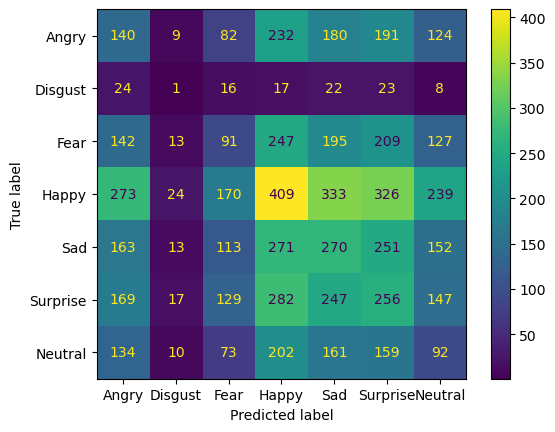

In [17]:
# Classification report
print(classification_report(validation_generator.classes, prediction.argmax(axis=1)))

# confusion matrix
c_matrix = confusion_matrix(validation_generator.classes, prediction.argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=class_dic.values())
cm_display.plot()